# Understanding a realisctic training pipeline - TRANSFER LEARNING

## Background: The Poisson Problem

The code implements a learning pipeline for solving the Poisson equation:

$$
-\Delta u = f
$$

where:
- $f$ is the forcing term (input)
- $u$ is the solution (output)
- $\Delta$ is the Laplacian operator

## Function Spaces for Forcing Terms

The experiment draws forcing terms f from three different function spaces, each with distinct characteristics:

1. **Gaussian Processes (GP)**:
   - Smooth, continuous functions characterized by a correlation structure
   - Generated using an RBF (Radial Basis Function) kernel
   - Tends to produce smooth, naturally-varying functions
   - Good for modeling physical phenomena that vary smoothly in space

2. **Piecewise Linear Functions (PL)**:
   - Functions composed of connected linear segments
   - Have discontinuous derivatives at breakpoints
   - Represent simpler, more geometric variations
   - Good for modeling systems with sharp transitions or regime changes

3. **Chebyshev Polynomials (CP)**:
   - Orthogonal polynomial basis functions
   - Can represent highly oscillatory behavior
   - More complex functional form than GP or PL
   - Good for modeling periodic or oscillatory phenomena

## Pipeline Structure

The code implements a complete experimental pipeline with several key components:

1. **Data Generation** (imported from separate module):
   ```python
   datasets = {
       'GP': gaussian_process_samples,
       'PL': piecewise_linear_samples,
       'CP': chebyshev_samples
   }
   ```

2. **Dataset Management**:
   - `PoissonDataset` class handles data organization and device placement
   - Converts numpy arrays to PyTorch tensors
   - Manages training/validation splits

3. **Model Training**:
   - Uses Fourier Neural Operator (FNO) architecture
   - Performs spectral convolutions in Fourier space
   - Includes early stopping and learning rate scheduling
   ```python
   model = trainer.train_model(
       model, train_dataset, run_name=f"{train_class}_base_training"
   )
   ```

4. **Transfer Learning Experiments**:
   - Zero-shot evaluation: Testing on different function spaces without retraining
   - Fine-tuning: Adapting pre-trained models to new function spaces
   ```python
   zero_shot_loss = trainer.evaluate(model, eval_loader)
   fine_tuned_model = trainer.fine_tune(model.clone(), fine_tune_dataset)
   ```

## Why This Matters

This experiment helps us understand:
1. How well neural operators generalize across different types of functions
2. The effectiveness of transfer learning in PDE solving
3. Which function spaces are "harder" to learn from or generalize to

The results often show that:
- Training on more complex spaces (CP) can lead to better generalization
- Similar spaces (GP and PL) transfer well to each other
- Fine-tuning can significantly improve performance on dissimilar spaces

## Key Implementation Details

1. **Early Stopping**:
   ```python
   if early_stopping(val_loss):
       print("Early stopping triggered")
       break
   ```
   Prevents overfitting by monitoring validation loss

2. **Best Model Tracking**:
   ```python
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       best_model_state = model.state_dict()
   ```
   Saves the best performing model during training

3. **Performance Visualization**:
   - Creates heatmaps comparing zero-shot and fine-tuned performance
   - Helps identify patterns in cross-space generalization

## Practical Considerations

When using this code:
1. Adjust hyperparameters based on your specific needs:
   - `modes`: More modes = better expressivity but slower training
   - `width`: Network width affects capacity and training stability
   - `batch_size`: Affects training stability and memory usage

2. Monitor training curves for:
   - Convergence behavior
   - Potential overfitting
   - Learning rate adjustment needs

This implementation provides a framework for understanding how neural operators learn and transfer knowledge across different function spaces in the context of PDE solving.

# Data generation


Your task will be to test the generalization properties of neural solvers when exposed to training terms outside the training distribution. The following algorithm, which is already implemented in the `data_generator` file will serve as your source of data.

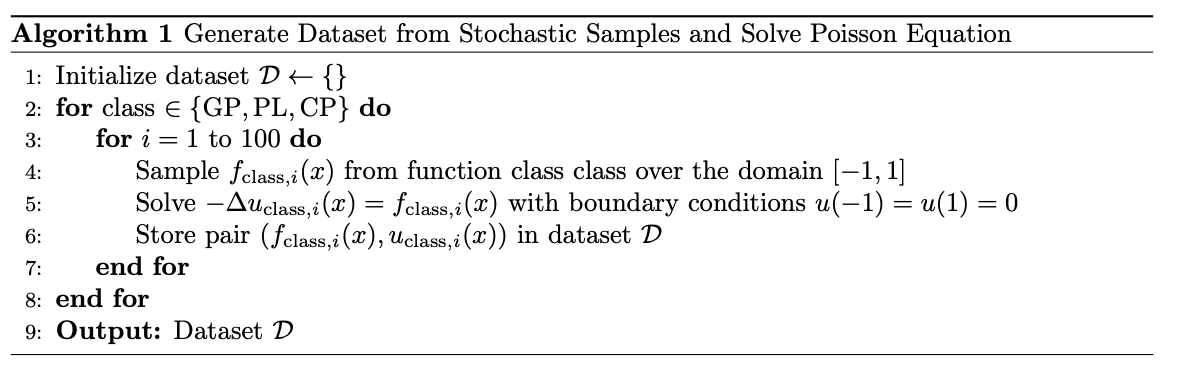

# Training

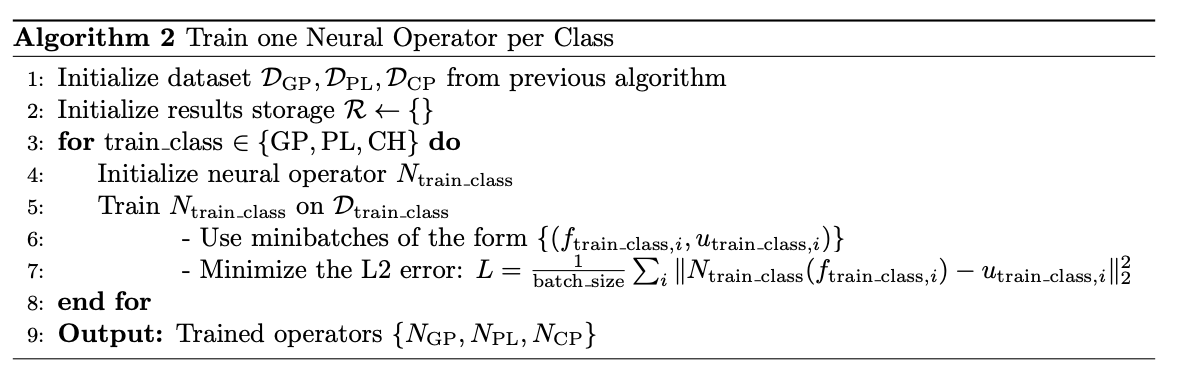

# Testing

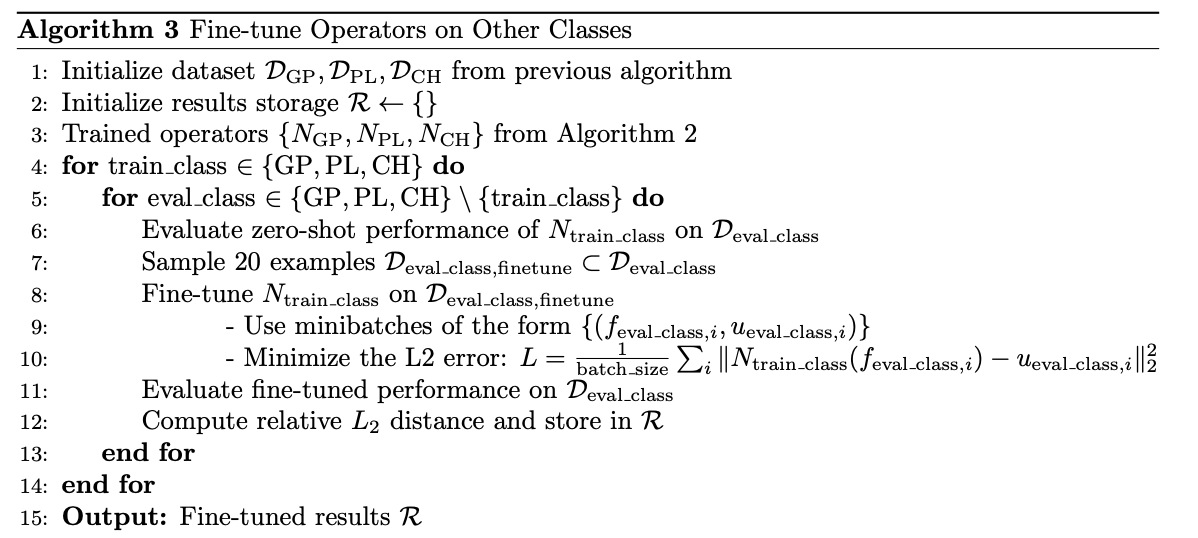

Generating GP samples...
Completed GP dataset generation
Generating PL samples...
Completed PL dataset generation
Generating CP samples...
Completed CP dataset generation


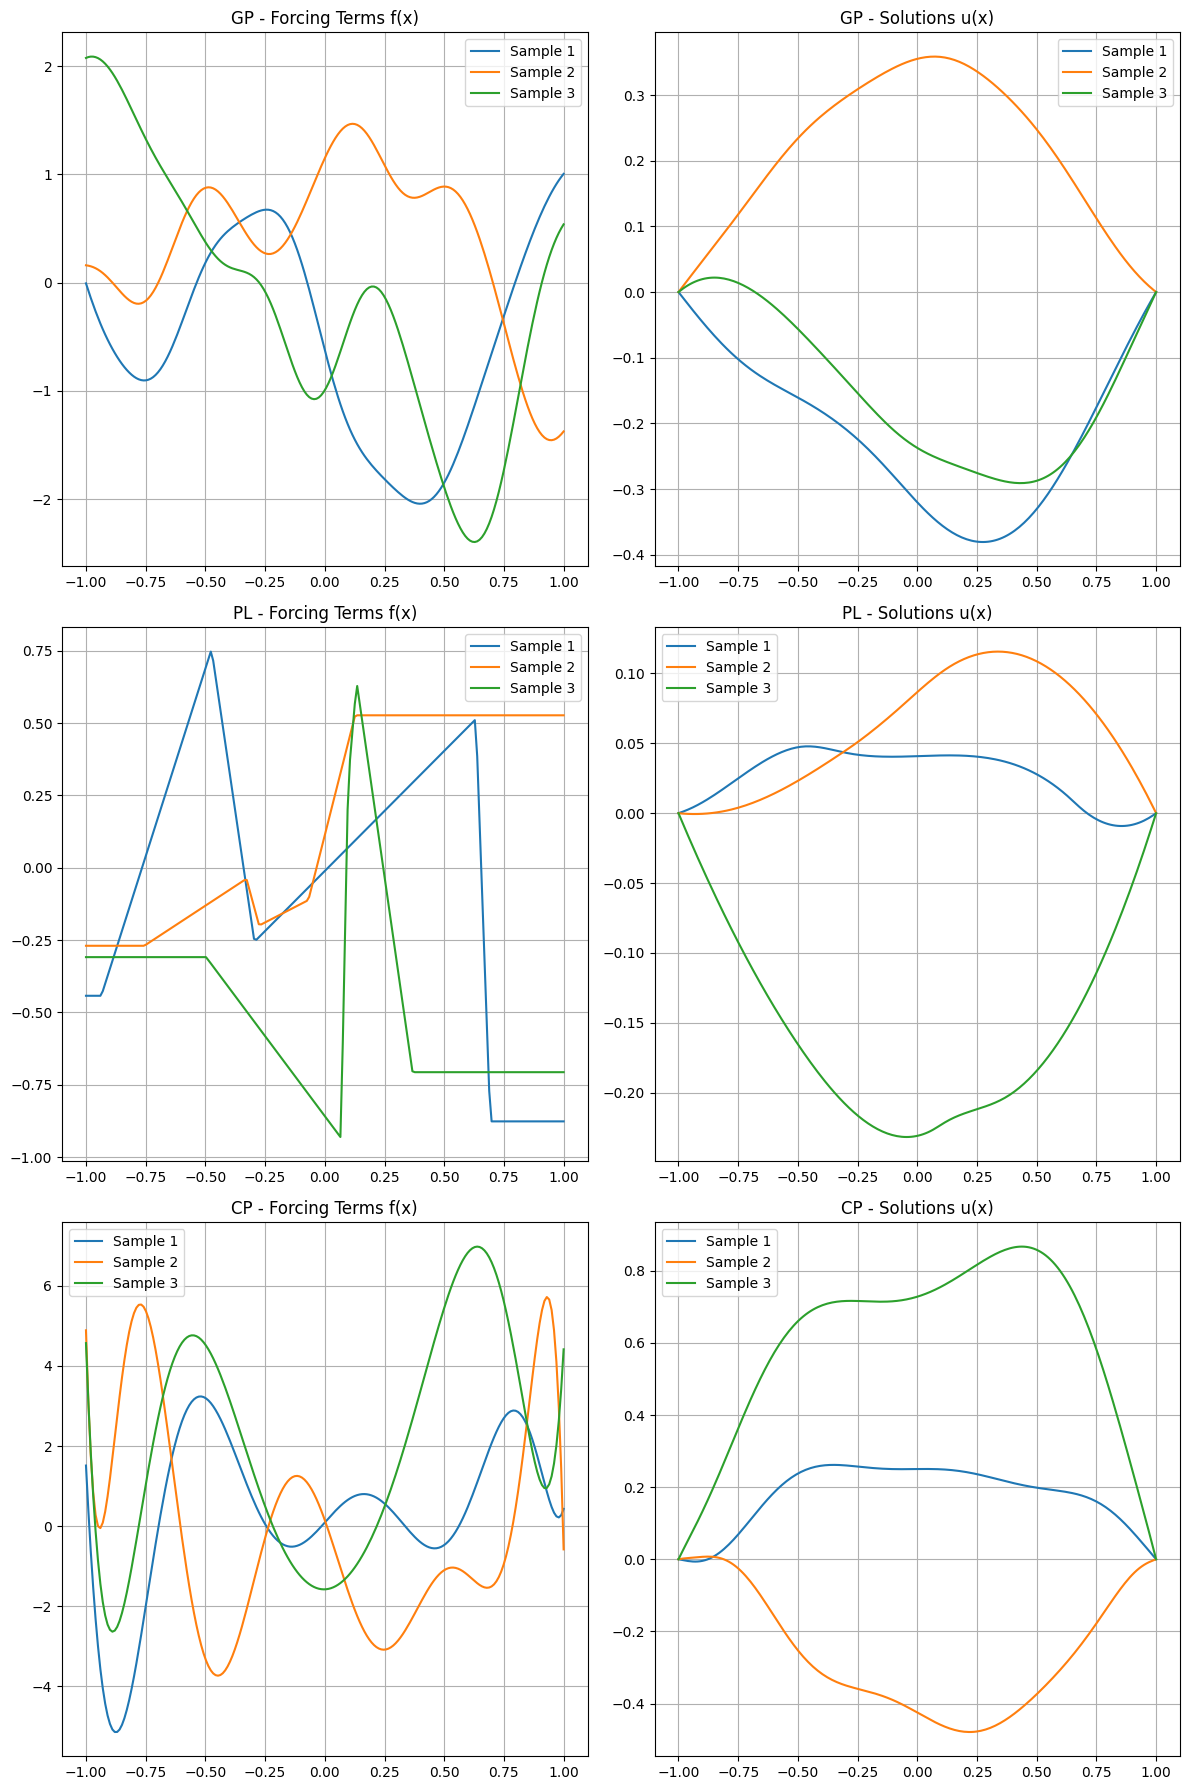

In [ ]:
import numpy as np
from scipy.linalg import solve_banded
from typing import Callable, List, Tuple, Dict
from dataclasses import dataclass
import matplotlib.pyplot as plt

@dataclass
class DomainConfig:
    """Configuration for the 1D domain"""
    x_min: float = -1.0
    x_max: float = 1.0
    n_points: int = 200

    @property
    def dx(self) -> float:
        return (self.x_max - self.x_min) / (self.n_points - 1)

    @property
    def x(self) -> np.ndarray:
        return np.linspace(self.x_min, self.x_max, self.n_points)

class PoissonSolver:
    """Finite difference solver for 1D Poisson equation"""
    def __init__(self, domain: DomainConfig):
        self.domain = domain
        self.setup_finite_difference_matrix()

    def setup_finite_difference_matrix(self):
        """Setup the banded matrix for finite differences"""
        n = self.domain.n_points - 2  # interior points
        dx = self.domain.dx

        # Setup the diagonal bands for the finite difference matrix
        main_diag = -2 * np.ones(n) / dx**2
        off_diag = np.ones(n-1) / dx**2

        # Store in banded matrix format for efficient solving
        self.matrix = np.zeros((3, n))
        self.matrix[0, 1:] = off_diag  # upper diagonal
        self.matrix[1, :] = main_diag  # main diagonal
        self.matrix[2, :-1] = off_diag  # lower diagonal

    def solve(self, f: np.ndarray) -> np.ndarray:
        """Solve -Δu = f with zero Dirichlet boundary conditions"""
        # Remove boundary points (they're zero)
        f_interior = -f[1:-1]

        # Solve the system
        u_interior = solve_banded((1, 1), self.matrix, f_interior)

        # Add back zero boundary conditions
        u = np.zeros_like(f)
        u[1:-1] = u_interior
        return u

class FunctionSampler:
    """Base class for function samplers"""
    def sample(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError

class GaussianProcessSampler(FunctionSampler):
    """Samples functions from a Gaussian Process with RBF kernel"""
    def __init__(self, length_scale: float = 0.2, sigma: float = 1.0):
        self.length_scale = length_scale
        self.sigma = sigma

    def rbf_kernel(self, x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
        """Compute RBF kernel matrix"""
        x1 = x1.reshape(-1, 1)
        x2 = x2.reshape(-1, 1)
        sq_dist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.sigma * np.exp(-0.5 * sq_dist / self.length_scale**2)

    def sample(self, x: np.ndarray) -> np.ndarray:
        """Sample a function from the GP"""
        K = self.rbf_kernel(x, x)
        L = np.linalg.cholesky(K + 1e-10 * np.eye(len(x)))
        return L @ np.random.standard_normal(len(x))

class PiecewiseLinearSampler(FunctionSampler):
    """Samples piecewise linear functions"""
    def __init__(self, n_segments: int = 5, y_scale: float = 1.0):
        self.n_segments = n_segments
        self.y_scale = y_scale

    def sample(self, x: np.ndarray) -> np.ndarray:
        """Sample a piecewise linear function"""
        # Generate random breakpoints
        breakpoints = np.sort(np.random.uniform(x[0], x[-1], self.n_segments))

        # Generate random y values at breakpoints
        y_values = np.random.uniform(-self.y_scale, self.y_scale, self.n_segments)

        # Interpolate
        return np.interp(x, breakpoints, y_values)

class ChebyshevSampler(FunctionSampler):
    """Samples random combinations of Chebyshev polynomials"""
    def __init__(self, max_degree: int = 10, coef_scale: float = 1.0):
        self.max_degree = max_degree
        self.coef_scale = coef_scale

    def chebyshev_polynomial(self, n: int, x: np.ndarray) -> np.ndarray:
        """Compute nth Chebyshev polynomial"""
        if n == 0:
            return np.ones_like(x)
        elif n == 1:
            return x
        else:
            T_n_minus_1 = x
            T_n_minus_2 = np.ones_like(x)
            for i in range(2, n + 1):
                T_n = 2 * x * T_n_minus_1 - T_n_minus_2
                T_n_minus_2 = T_n_minus_1
                T_n_minus_1 = T_n
            return T_n

    def sample(self, x: np.ndarray) -> np.ndarray:
        """Sample a random combination of Chebyshev polynomials"""
        coefficients = np.random.normal(0, self.coef_scale, self.max_degree)
        result = np.zeros_like(x)
        for n in range(self.max_degree):
            result += coefficients[n] * self.chebyshev_polynomial(n, x)
        return result

class DatasetGenerator:
    """Main class for generating the Poisson equation dataset"""
    def __init__(self, domain: DomainConfig):
        self.domain = domain
        self.solver = PoissonSolver(domain)
        self.samplers = {
            'GP': GaussianProcessSampler(),
            'PL': PiecewiseLinearSampler(),
            'CP': ChebyshevSampler()
        }

    def generate_dataset(self, n_samples: int = 100) -> Dict[str, List[Tuple[np.ndarray, np.ndarray]]]:
        """Generate dataset according to Algorithm 1"""
        dataset = {}

        for sampler_name, sampler in self.samplers.items():
            print(f"Generating {sampler_name} samples...")
            dataset[sampler_name] = []

            for i in range(n_samples):
                # Sample forcing term
                f = sampler.sample(self.domain.x)

                # Solve Poisson equation
                u = self.solver.solve(f)

                # Store pair
                dataset[sampler_name].append((f, u))

            print(f"Completed {sampler_name} dataset generation")

        return dataset

    def plot_samples(self, dataset: Dict[str, List[Tuple[np.ndarray, np.ndarray]]], n_samples: int = 3):
        """Plot some samples from each function class"""
        fig, axes = plt.subplots(len(self.samplers), 2, figsize=(12, 6*len(self.samplers)))

        for i, (sampler_name, samples) in enumerate(dataset.items()):
            for j in range(n_samples):
                f, u = samples[j]
                axes[i,0].plot(self.domain.x, f, label=f'Sample {j+1}')
                axes[i,1].plot(self.domain.x, u, label=f'Sample {j+1}')

            axes[i,0].set_title(f'{sampler_name} - Forcing Terms f(x)')
            axes[i,1].set_title(f'{sampler_name} - Solutions u(x)')
            axes[i,0].legend()
            axes[i,1].legend()
            axes[i,0].grid(True)
            axes[i,1].grid(True)

        plt.tight_layout()
        return fig

# Example usage
if __name__ == "__main__":
    # Setup domain
    domain = DomainConfig(x_min=-1.0, x_max=1.0, n_points=200)

    # Create generator
    generator = DatasetGenerator(domain)

    # Generate dataset
    dataset = generator.generate_dataset(n_samples=100)

    # Plot some samples
    fig = generator.plot_samples(dataset, n_samples=3)
    plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

@dataclass
class TrainingConfig:
    """Configuration for training"""
    batch_size: int = 16
    learning_rate: float = 0.001
    epochs: int = 50
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    early_stopping_patience: int = 5
    fine_tuning_epochs: int = 20
    fine_tuning_lr: float = 0.0005
    modes: int = 12
    width: int = 32

class PoissonDataset(Dataset):
    """Dataset class for Poisson equation data"""
    def __init__(self, data: List[Tuple[np.ndarray, np.ndarray]], device=None):
        self.forcing_terms = torch.tensor(np.stack([f for f, _ in data]), dtype=torch.float32)
        self.solutions = torch.tensor(np.stack([u for _, u in data]), dtype=torch.float32)
        if device is not None:
            self.forcing_terms = self.forcing_terms.to(device)
            self.solutions = self.solutions.to(device)

    def __len__(self):
        return len(self.forcing_terms)

    def __getitem__(self, idx):
        return self.forcing_terms[idx], self.solutions[idx]

class SpectralConv1d(nn.Module):
    """1D Fourier layer"""
    def __init__(self, in_channels: int, out_channels: int, modes: int):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.weights = nn.Parameter(
            torch.complex(
                torch.randn(in_channels, out_channels, self.modes) / np.sqrt(in_channels),
                torch.randn(in_channels, out_channels, self.modes) / np.sqrt(in_channels)
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)

        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,
                           device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes] = torch.einsum(
            "bix,iox->box",
            x_ft[:, :, :self.modes],
            self.weights
        )

        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    """Fourier Neural Operator for 1D problems"""
    def __init__(self, modes: int, width: int):
        super().__init__()

        self.modes = modes
        self.width = width

        self.fc0 = nn.Linear(1, self.width)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes)

        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

        self.activation = torch.nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.unsqueeze(1)
        x = self.fc0(x.transpose(1, 2))
        x = x.transpose(1, 2)

        x1 = self.activation(self.conv0(x) + self.w0(x))
        x2 = self.activation(self.conv1(x1) + self.w1(x1))
        x3 = self.activation(self.conv2(x2) + self.w2(x2))
        x4 = self.activation(self.conv3(x3) + self.w3(x3))

        x = x4.transpose(1, 2)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)

        return x.squeeze(-1)

class EarlyStopping:
    """Early stopping handler"""
    def __init__(self, patience: int = 5, min_delta: float = 0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss: float) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

class ModelTrainer:
    """Handles training and evaluation of FNO models"""
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch.device(config.device)

    def train_epoch(self, model: nn.Module, train_loader: DataLoader,
                   optimizer: torch.optim.Optimizer) -> float:
        model.train()
        total_loss = 0.0

        for f, u in train_loader:
            f, u = f.to(self.device), u.to(self.device)

            optimizer.zero_grad()
            u_pred = model(f)
            loss = nn.MSELoss()(u_pred, u)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    @torch.no_grad()
    def evaluate(self, model: nn.Module, val_loader: DataLoader) -> float:
        model.eval()
        total_loss = 0.0

        for f, u in val_loader:
            f, u = f.to(self.device), u.to(self.device)
            u_pred = model(f)
            loss = nn.MSELoss()(u_pred, u)
            total_loss += loss.item()

        return total_loss / len(val_loader)

    def train_model(self, model: nn.Module, train_dataset: Dataset,
                   val_dataset: Optional[Dataset] = None,
                   run_name: str = "base_training") -> nn.Module:
        if val_dataset is None:
            train_size = int(0.8 * len(train_dataset))
            val_size = len(train_dataset) - train_size
            train_dataset, val_dataset = torch.utils.data.random_split(
                train_dataset, [train_size, val_size]
            )

        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config.batch_size, shuffle=False)

        model = model.to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.config.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5)
        early_stopping = EarlyStopping(patience=self.config.early_stopping_patience)

        best_val_loss = float('inf')
        best_model_state = None

        for epoch in range(self.config.epochs):
            train_loss = self.train_epoch(model, train_loader, optimizer)
            val_loss = self.evaluate(model, val_loader)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()

            print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

            scheduler.step(val_loss)
            if early_stopping(val_loss):
                print("Early stopping triggered")
                break

        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        return model

    def fine_tune(self, model: nn.Module, fine_tune_dataset: Dataset,
                 run_name: str = "fine_tuning") -> nn.Module:
        optimizer = optim.Adam(model.parameters(), lr=self.config.fine_tuning_lr)

        train_size = int(0.8 * len(fine_tune_dataset))
        val_size = len(fine_tune_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(
            fine_tune_dataset, [train_size, val_size]
        )

        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config.batch_size, shuffle=False)

        best_val_loss = float('inf')
        best_model_state = None

        for epoch in range(self.config.fine_tuning_epochs):
            train_loss = self.train_epoch(model, train_loader, optimizer)
            val_loss = self.evaluate(model, val_loader)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()

            print(f"Fine-tuning Epoch {epoch}: "
                  f"Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")

        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        return model

In [ ]:
def run_experiment(datasets: Dict[str, List[Tuple[np.ndarray, np.ndarray]]], config: TrainingConfig, fine_tune_size: int = 20):
    """Run complete experiment pipeline"""
    results = {}
    models = {}
    trainer = ModelTrainer(config)

    os.makedirs("results", exist_ok=True)

    for train_class in datasets.keys():
        print(f"\nTraining model for {train_class}")
        train_dataset = PoissonDataset(datasets[train_class], device=config.device)

        model = FNO1d(modes=config.modes, width=config.width)
        model = model.to(config.device)

        model = trainer.train_model(
            model, train_dataset, run_name=f"{train_class}_base_training"
        )
        models[train_class] = model

        results[train_class] = {}
        for eval_class in datasets.keys():
            if eval_class != train_class:
                print(f"\nEvaluating {train_class} model on {eval_class} data")
                eval_dataset = PoissonDataset(datasets[eval_class], device=config.device)
                eval_loader = DataLoader(eval_dataset, batch_size=config.batch_size, shuffle=False)
                zero_shot_loss = trainer.evaluate(model, eval_loader)

                fine_tune_size = fine_tune_size
                fine_tune_data = datasets[eval_class][:fine_tune_size]
                fine_tune_dataset = PoissonDataset(fine_tune_data, device=config.device)

                fine_tuned_model = FNO1d(modes=config.modes, width=config.width)
                fine_tuned_model.to(config.device)
                fine_tuned_model.load_state_dict(model.state_dict())

                fine_tuned_model = trainer.fine_tune(
                    fine_tuned_model, fine_tune_dataset,
                    run_name=f"{train_class}_to_{eval_class}_fine_tuning"
                )

                fine_tuned_loss = trainer.evaluate(fine_tuned_model, eval_loader)

                results[train_class][eval_class] = {
                    'zero_shot_loss': zero_shot_loss,
                    'fine_tuned_loss': fine_tuned_loss
                }

    plot_results(results)
    return results, models

def plot_results(results: Dict):
    """Plot experiment results"""
    function_classes = list(results.keys())
    n_classes = len(function_classes)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    zero_shot_matrix = np.zeros((n_classes, n_classes))
    fine_tuned_matrix = np.zeros((n_classes, n_classes))

    for i, train_class in enumerate(function_classes):
        for j, eval_class in enumerate(function_classes):
            if train_class != eval_class:
                zero_shot_matrix[i, j] = results[train_class][eval_class]['zero_shot_loss']
                fine_tuned_matrix[i, j] = results[train_class][eval_class]['fine_tuned_loss']

    im1 = ax1.imshow(zero_shot_matrix, cmap='viridis')
    ax1.set_title('Zero-shot Performance (MSE)')
    ax1.set_xticks(range(n_classes))
    ax1.set_yticks(range(n_classes))
    ax1.set_xticklabels(function_classes)
    ax1.set_yticklabels(function_classes)
    ax1.set_xlabel('Evaluation Class')
    ax1.set_ylabel('Training Class')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(fine_tuned_matrix, cmap='viridis')
    ax2.set_title('Fine-tuned Performance (MSE)')
    ax2.set_xticks(range(n_classes))
    ax2.set_yticks(range(n_classes))
    ax2.set_xticklabels(function_classes)
    ax2.set_yticklabels(function_classes)
    ax2.set_xlabel('Evaluation Class')
    ax2.set_ylabel('Training Class')
    plt.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.savefig("results/performance_comparison.png")
    plt.close()

if __name__ == "__main__":
    # Setup configurations
    domain_config = DomainConfig(
        x_min=-1.0,
        x_max=1.0,
        n_points=128  # Reduced for faster computation
    )

    ######
    # TO DO: Vary the architecture and hyperparameters. What is their impact?
    ######

    training_config = TrainingConfig(
        batch_size=16,
        learning_rate= 0.001,
        epochs = 100,
        device="cuda" if torch.cuda.is_available() else "cpu",
        early_stopping_patience=10,
        fine_tuning_epochs=50,
        fine_tuning_lr= 0.0001,
        modes=16,
        width=48
    )

    print("Generating datasets...")
    generator = DatasetGenerator(domain_config)

    ######
    # TO DO: Vary the number of training_samples and
    #        observe the performance change ath the downstream level
    ######

    datasets = generator.generate_dataset(n_samples=128)  # This will generate GP, PL, and CP datasets

    print("Starting experiment...")
    print(f"Using device: {training_config.device}")
    print(f"Dataset sizes:")
    for class_name, data in datasets.items():
        print(f"{class_name}: {len(data)} samples")

    # Run experiment
    try:

        ######
        # TO DO: Vary the number of fine_tune_size and
        #        observe the performance change at the downstream level
        ######
        results, models = run_experiment(datasets, training_config, fine_tune_size = 32)

        # Print summary
        print("\nExperiment Results Summary:")
        for train_class in results.keys():
            print(f"\nModel trained on {train_class}:")
            for eval_class in results[train_class].keys():
                zero_shot = results[train_class][eval_class]['zero_shot_loss']
                fine_tuned = results[train_class][eval_class]['fine_tuned_loss']
                print(f"  {eval_class} data:")
                print(f"    Zero-shot MSE: {zero_shot:.6f}")
                print(f"    Fine-tuned MSE: {fine_tuned:.6f}")
                print(f"    Improvement: {(1 - fine_tuned/zero_shot)*100:.2f}%")

        # Save models
        os.makedirs("models", exist_ok=True)
        for class_name, model in models.items():
            torch.save(model.state_dict(), f"models/fno_{class_name}.pt")

        print("\nExperiment completed successfully!")
        print("Results have been plotted to 'results/performance_comparison.png'")
        print("Models have been saved to the 'models' directory")

    except Exception as e:
        print(f"An error occurred during the experiment: {str(e)}")
        raise

Generating datasets...
Generating GP samples...
Completed GP dataset generation
Generating PL samples...
Completed PL dataset generation
Generating CP samples...
Completed CP dataset generation
Starting experiment...
Using device: cuda
Dataset sizes:
GP: 128 samples
PL: 128 samples
CP: 128 samples

Training model for GP
Epoch 0: Train Loss = 0.022413, Val Loss = 0.010424
Epoch 1: Train Loss = 0.010388, Val Loss = 0.009784
Epoch 2: Train Loss = 0.008395, Val Loss = 0.008156
Epoch 3: Train Loss = 0.007216, Val Loss = 0.008963
Epoch 4: Train Loss = 0.006926, Val Loss = 0.007690
Epoch 5: Train Loss = 0.006457, Val Loss = 0.007886
Epoch 6: Train Loss = 0.005668, Val Loss = 0.009030
Epoch 7: Train Loss = 0.005900, Val Loss = 0.006777
Epoch 8: Train Loss = 0.004296, Val Loss = 0.006934
Epoch 9: Train Loss = 0.004060, Val Loss = 0.007537
Epoch 10: Train Loss = 0.003371, Val Loss = 0.006816
Epoch 11: Train Loss = 0.003035, Val Loss = 0.006250
Epoch 12: Train Loss = 0.002541, Val Loss = 0.006656

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Appendix A: Function Space Specifications



## A.1 Gaussian Process (GP) with RBF Kernel

Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space. A Gaussian process $f: \mathbb{R} \to L^2(\Omega)$ is characterized by the property that any finite collection $(f(x_1), ..., f(x_n))$ follows a multivariate normal distribution.

**Definition A.1.1** (Gaussian Process)
A GP is completely specified by its first two moments:
- Mean function: $m(x) = \mathbb{E}[f(x)]$
- Covariance function: $k(x,x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))]$

For our implementation, we use the radial basis function (RBF) kernel:

**Definition A.1.2** (RBF Kernel)
$k(x,x') = \sigma_f^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right)$

where $\sigma_f^2$ is the signal variance and $l$ is the characteristic length scale.

For discretized sampling, let $\mathbf{x} = (x_1,\ldots,x_n)$ be a finite set of points. Then:
$f(\mathbf{x}) \sim \mathcal{N}(\mathbf{m}, K)$
where $K_{ij} = k(x_i,x_j)$ is the Gram matrix.

## A.2 Piecewise Linear Functions (PL)

**Definition A.2.1** (Piecewise Linear Function)
Let $[a,b]$ be a closed interval and $\{x_0,x_1,\ldots,x_k\}$ be a partition where $a=x_0 < x_1 < \cdots < x_k=b$. A piecewise linear function $f:[a,b]\to\mathbb{R}$ is defined as:

$f(x) = \begin{cases}
\alpha_1x + \beta_1 & x \in [x_0,x_1] \\
\alpha_2x + \beta_2 & x \in [x_1,x_2] \\
\vdots & \vdots \\
\alpha_kx + \beta_k & x \in [x_{k-1},x_k]
\end{cases}$

where $\alpha_i,\beta_i \in \mathbb{R}$ and continuity is enforced at breakpoints:
$\alpha_ix_i + \beta_i = \alpha_{i+1}x_i + \beta_{i+1}$ for $i=1,\ldots,k-1$

## A.3 Chebyshev Polynomials (CP)

**Definition A.3.1** (Chebyshev Polynomials)
The Chebyshev polynomials $\{T_n(x)\}_{n=0}^\infty$ form an orthogonal basis with respect to the weight function $w(x)=\frac{1}{\sqrt{1-x^2}}$ on $[-1,1]$. They satisfy:

1. Initial conditions:
   - $T_0(x) = 1$
   - $T_1(x) = x$

2. Recurrence relation:
   - $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$ for $n \geq 1$

**Definition A.3.2** (Random Chebyshev Series)
A random function in the Chebyshev space is defined as:

$f(x) = \sum_{i=0}^{N-1} c_iT_i(x)$

where $c_i$ are i.i.d. random variables, typically chosen as $c_i \sim \mathcal{N}(0,\sigma_i^2)$ with $\sigma_i^2$ decreasing with $i$ to ensure smoothness.

**Properties:**
1. $T_n(\cos\theta) = \cos(n\theta)$
2. $\|T_n\|_{L^2_w[-1,1]} = \begin{cases}\pi & n=0 \\ \pi/2 & n>0\end{cases}$
3. The polynomials satisfy the discrete orthogonality relation on Chebyshev nodes.

This construction provides a rich space of functions suitable for testing operator learning algorithms, with increasing complexity from PL to GP to CP in terms of their functional expressivity.